In [ ]:
from sklearn.datasets import load_digits
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
# Load the digits dataset
digits = load_digits()
data, target = digits.data, digits.target
data_and_target = [(data[i], target[i]) for i in range(len(data))]


In [ ]:
# # Plot the first few images to verify the dataset
# num_images_to_plot = 10
# images = digits.images
# for i in range(num_images_to_plot):
#     plt.gray()
#     plt.matshow(images[i])

#data should be between 0 and 1
max = np.max(data)
scaled_data = [data[i] /max for i in range(len(data))]

#encode
target_encoded = []

for t in target:
  one_hot = [0]*10
  one_hot[t] = 1
  target_encoded.append(one_hot)

data_pairs = [(list(scaled_data[i]), target_encoded[i]) for i in range(len(data))]


def create_minibatches(size):
    shuffle_set = data_pairs
    random.shuffle(shuffle_set)
    return shuffle_set[:size]


In [ ]:
#Sigmoid Activation Object
class SigmoidActivation():
  #forward
  def __call__(self,inputs):
    return 1.0/(1.0 + np.exp(-inputs))

  #backprop step
  def backward(self, preactivation, error_signal):
      # Calculate the derivative of the sigmoid with respect to the pre-activation
      sigmoid_activation = SigmoidActivation()
      s = sigmoid_activation(preactivation)
      sigmoid_derivative = s * (1 - s)

      # Calculate the gradient of the loss with respect to the pre-activation
      gradient = np.dot(sigmoid_derivative,error_signal)
      return gradient


In [ ]:
#Softmax activation
class SoftmaxActivation():
    #forward
    def __call__(self, inputs):
        exp_inputs = np.exp(inputs - np.max(inputs))
        output = exp_inputs / np.sum(exp_inputs)
        return output

In [ ]:
class CCELoss():
    def __call__(self, predictions, targets):
        # shape.predictions = (minibatchsize, prediction_size = 10)
        # shape.targets = (minibatchsize, prediction_size = 10)
        output = []
        for prediction,target in zip(predictions,targets):
          loss = -np.sum(target * np.log(prediction))
          output.append(loss)
        return output

    def backwards(self, predictions, targets):
        # Calculate the gradient of loss w.r.t. predicted values (ˆy)
        output = []
        for prediction,target in zip(predictions,targets):
          gradient = np.sum(prediction - target)
          output.append(gradient)
        return output

In [ ]:
from numpy.core.fromnumeric import shape
class MLP_layer():

  def __init__(self, num_inputs, num_units, activation_function):
    #num_input: num of units in preceiding layer
    #num_units: how many single perceptrons do we have in this layer?
    #weights: 2-d array of size (num_units, num_inputs)
    self.num_inputs = num_inputs
    self.num_units = num_units
    self.activation_function = activation_function
    self.bias = np.zeros((self.num_units,))
    self.weights = np.random.normal(loc=0, scale=0.2, size=(self.num_units, self.num_inputs))
    self.pre_activations = []
    self.alpha = 1


  def set_weights(self, weights, bias):
    self.weights = weights
    self.bias = bias

  def forward(self, x):
    output = []
    for unit in x:
      self.pre_activations = self.weights @ unit + np.transpose(self.bias)
      self.activations = self.activation_function(self.pre_activations)
      output.append(self.activations)
    return output

  def backward(self, delta):

    for weight,b,pre_activation in zip(self.weights,self.bias,self.pre_activations):
      weight -= self.alpha * delta* pre_activation
      b -= self.alpha * delta


In [ ]:
class MLP():
  def __init__(self, size_list): #sizelist [64, 5, 4, 10]
    #size_list contains sizes of
    self.num_layers = len(size_list)
    self.size_list = size_list
    self.layer_list = []
    transformed_sizeList = [64] + self.size_list #input size is 64 in the beginning
    #list of mlp layers
    for i in range(self.num_layers):
      mlp = MLP_layer(transformed_sizeList[i], transformed_sizeList[i+1], SigmoidActivation())
      self.layer_list.append(mlp)
    #output layer
    self.layer_list.append(MLP_layer(self.size_list[self.num_layers-1], 10, SoftmaxActivation()))


  def forward(self, input):
    for layer in self.layer_list:
      output = layer.forward(input)
      input = output
    return output


  def backward(self, derivate_loss):
    #for output layer
    output_layer = self.layer_list[-1]
    sigmoid = SigmoidActivation()
    delta_ol = sigmoid.backward(output_layer.pre_activations, derivate_loss)# activation/ loss

    output_layer.backward(delta_ol)
    for i in reversed(range(self.num_layers-1)):
        current_layer = self.layer_list[i]
        delta_hl = sigmoid.backward(current_layer.pre_activations,current_layer.weights)
        current_layer.backward(delta_hl)

In [ ]:
epochs = 10
mlp = MLP([20,10])
minibatches = create_minibatches(10)

inputs = []
targets = []
for pair in minibatches:
   inputs += [pair[0]]
   targets += [pair[1]]

arr_loss = np.zeros(epochs)

for epoch in range(epochs):

    accuracy = 0
    loss = 0

    #forward step
    predictions = mlp.forward(inputs) # outcome of our mlp

    loss_function = CCELoss()
    #backward step
    derivate_loss = loss_function.backwards(predictions, targets)

    for loss in derivate_loss:
      mlp.backward(loss)

    # accuracy and loss is calculated and summed up
    for i in range(len(predictions)):

      loss += np.sum(loss_function(predictions, targets))

    arr_loss[epoch] = loss/len(inputs)


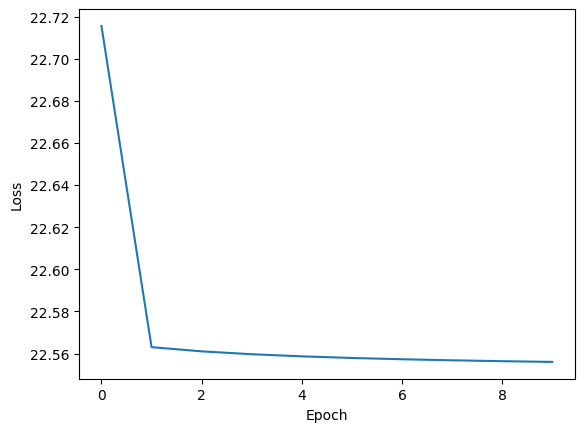

In [ ]:
#Visulalisation of loss
plt.figure()
plt.plot(range(epochs),arr_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()